# 과적합 해결

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms  # 이미지데이터 변환을 수행하는 도구들
import torchvision.datasets as datasets

### 배치 정규화 적용

In [3]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])    # ToTensor : 파이토치의 텐서 형태로 변환 / Normalize : 평균 0.5, 표준편차 0.5로 정규화
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)         # 이미지 데이터 / train=Ture: 학습용 데이터를 가져옴. False면 테스트 데이터 / transform의 내용대로 적용 / download=True: 해당되는 내용이 없으면 자동으로 다운로드 

100.0%
100.0%
100.0%
100.0%


In [ ]:
# 데이터 분할
train_size = int(0.8 * len(dataset))    # 80%를 train size로 (학습데이터셋)
val_size = len(dataset) - train_size    # 전체 데이터셋 사이즈에서 train size만큼 빼서 validation size로 (검증데이터셋셋)

train_data, val_data = random_split(dataset, [train_size, val_size])    # 무작위로 데이터셋을 분할. random_split(대상 데이터셋, 데이터셋을 나눠줄 비율)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)      # DataLoader(사용할 데이터셋, 배치사이즈 (한번 부를 때마다 64개의 데이터를 준다), 셔플(True면 랜덤으로, False면 순서대로)) / 데이터를 배치크기로 나누어 로드할 수 있다
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)         # 예를 들어 샘플이 1000개, 배치크기가 100이라면 한번에 100개의 샘플씩 모델에 데이터를 제공하고, 총 10번 배치가 돌아감

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 28 * 28 형태의 데이터 128개의 은닉층 뉴런에 통과시킴
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity() # 층 사이사이에 배치정규화 적용 여부 / use_bn = True라면 배치노멀라이즈, False라면 nn.Identity() (입력값을 아무런 연산없이 그대로 돌려줌. 항등함수)
        self.fc2 = nn.Linear(128, 64)       # 128개를 입력받아 64개를 출력하는 은닉층
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)        # 64개를 입력받아 10개를 출력하는 출력층 

    def forward(self, x):
        x = x.view(x.size(0), -1)   # 1차원의 벡터로 변환 (flatten 효과), x.size(0) : 배치크기 유지. (배치크기, h, w) -> (배치크기 그대로, 특성)
        x = torch.relu(self.bn1(self.fc1(x)))   # 연산 -> batch normalization -> 활성화함수 
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [20]:
# 학습함수
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()   # 모델에 대해 학습모드로 사용하겠다는 설정 
        for images, labels in train_loader: # train_loader에서 설정한 배치사이즈만큼 불러옴 
            images = images.view(images.size(0), -1)    # 이미지 데이터 flatten 
            optimizer.zero_grad()   # 기울기를 초기화
            outputs = model(images) # 모델을 통과한 결과값
            loss = criterion(outputs, labels)   # 에측값과 실제값을 넣어 손실 계산
            loss.backward() # 역전파
            optimizer.step() # 가중치 업데이트
        
        model.eval()    # evaluation. 테스트 모드(검증 모드)  / 여기서는 적용하지 않았지만 드롭아웃을 적용한다면 train모드에서는 드롭아웃이 적용되지만, eval 모드에서는 적용되지 않는다는 차이가 있다 
        val_loss = 0    # 초기화
        correct = 0     # 초기화
        with torch.no_grad():   # 학습이 아닌 검증이기 때문에 기울기 계산이 필요 없으니 기울기, 가중치의 계산을 비활성화 / 이 코드가 없어도 실행에 문제는 없지만, 기울기 계산을 비활성화해서 메모리 낭비를 줄이는 효과를 가져다줌 
            for images, labels in val_loader:   # val_loader로 검증 데이터에 대한 내용을 배치사이즈대로 로드해줌
                images = images.view(images.size(0), -1)    # flatten
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()   # 손실 계산. .item() : 텐서로 갖고 있는 값을 스칼라 값으로 변환시켜 val_loss에 누적
                preds = outputs.argmax(dim=1)   # 각 배치에 대해 예측값 중 가장 높은 확률을 가진 클래스를 선택
                correct += (preds == labels).sum().item()

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [11]:
print('배치 정규화 적용 안함')
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print('\n배치 정규화 적용')
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)


배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2541, Accuracy: 0.9257
Epoch 2 | Val Loss: 0.1805, Accuracy: 0.9487
Epoch 3 | Val Loss: 0.1546, Accuracy: 0.9541
Epoch 4 | Val Loss: 0.1364, Accuracy: 0.9603
Epoch 5 | Val Loss: 0.1303, Accuracy: 0.9611

배치 정규화 적용
Epoch 1 | Val Loss: 0.1278, Accuracy: 0.9624
Epoch 2 | Val Loss: 0.0936, Accuracy: 0.9723
Epoch 3 | Val Loss: 0.0840, Accuracy: 0.9748
Epoch 4 | Val Loss: 0.0794, Accuracy: 0.9753
Epoch 5 | Val Loss: 0.0810, Accuracy: 0.9752


In [ ]:
for batch_size in [16, 32, 128]:
    print(f'batch size: {batch_size}')
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

# 배치사이즈가 작은 것이 로스가 작고 정확도가 높은 것을 볼 수 있다. 하지만 항상 그런 것이 아니고, 우리가 적절한 배치사이즈를 정해주는 것이 성능 개선에 도움이 된다 

batch size: 16
Epoch 1 | Val Loss: 0.1266, Accuracy: 0.9634
Epoch 2 | Val Loss: 0.1072, Accuracy: 0.9674
Epoch 3 | Val Loss: 0.0912, Accuracy: 0.9722
Epoch 4 | Val Loss: 0.0792, Accuracy: 0.9768
Epoch 5 | Val Loss: 0.0828, Accuracy: 0.9748
batch size: 32
Epoch 1 | Val Loss: 0.1248, Accuracy: 0.9643
Epoch 2 | Val Loss: 0.0961, Accuracy: 0.9711
Epoch 3 | Val Loss: 0.0833, Accuracy: 0.9742
Epoch 4 | Val Loss: 0.0746, Accuracy: 0.9776
Epoch 5 | Val Loss: 0.0778, Accuracy: 0.9774
batch size: 128
Epoch 1 | Val Loss: 0.1491, Accuracy: 0.9576
Epoch 2 | Val Loss: 0.1110, Accuracy: 0.9683
Epoch 3 | Val Loss: 0.0903, Accuracy: 0.9723
Epoch 4 | Val Loss: 0.1013, Accuracy: 0.9678
Epoch 5 | Val Loss: 0.0905, Accuracy: 0.9696


### 드롭아웃 적용

In [13]:
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

for rate in [0.2, 0.5, 0.8]:
    print(f'Dropout Rate: {rate}')
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)  # dropout도 적절하게 조절해줘야한다

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2492, Accuracy: 0.9268
Epoch 2 | Val Loss: 0.1971, Accuracy: 0.9405
Epoch 3 | Val Loss: 0.1734, Accuracy: 0.9479
Epoch 4 | Val Loss: 0.1526, Accuracy: 0.9543
Epoch 5 | Val Loss: 0.1436, Accuracy: 0.9559
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3282, Accuracy: 0.9059
Epoch 2 | Val Loss: 0.2769, Accuracy: 0.9209
Epoch 3 | Val Loss: 0.2593, Accuracy: 0.9218
Epoch 4 | Val Loss: 0.2312, Accuracy: 0.9319
Epoch 5 | Val Loss: 0.2196, Accuracy: 0.9361
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.4069, Accuracy: 0.7227
Epoch 2 | Val Loss: 1.2810, Accuracy: 0.7729
Epoch 3 | Val Loss: 1.1803, Accuracy: 0.7699
Epoch 4 | Val Loss: 1.1789, Accuracy: 0.7821
Epoch 5 | Val Loss: 1.1085, Accuracy: 0.8181


- 훈련 시 드롭아웃 활성화, 테스트 시 비활성화

In [ ]:
# 학습함수
def train_do(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        for images, labels in train_loader: # train_loader에서 설정한 배치사이즈만큼 불러옴 
            images = images.view(images.size(0), -1)    # 이미지 데이터 flatten 
            optimizer.zero_grad()   # 기울기를 초기화
            outputs = model(images) # 모델을 통과한 결과값
            loss = criterion(outputs, labels)   # 에측값과 실제값을 넣어 손실 계산
            loss.backward() # 역전파
            optimizer.step() # 가중치 업데이트
        
        val_loss = 0    # 초기화
        correct = 0     # 초기화
        with torch.no_grad():   # 학습이 아닌 검증이기 때문에 기울기 계산이 필요 없으니 기울기, 가중치의 계산을 비활성화 / 이 코드가 없어도 실행에 문제는 없지만, 기울기 계산을 비활성화해서 메모리 낭비를 줄이는 효과를 가져다줌 
            for images, labels in val_loader:   # val_loader로 검증 데이터에 대한 내용을 배치사이즈대로 로드해줌
                images = images.view(images.size(0), -1)    # flatten
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()   # 손실 계산. .item() : 텐서로 갖고 있는 값을 스칼라 값으로 변환시켜 val_loss에 누적
                preds = outputs.argmax(dim=1)   # 각 배치에 대해 예측값 중 가장 높은 확률을 가진 클래스를 선택. 각 이미지에 대해 예측된 클래스를 추출
                correct += (preds == labels).sum().item()   # 예측한 클래스와 실제 클래스가 일치하는지 비교하는 Boolean 텐서를 생성 -> sum()을 호출하여 맞힌 클래스의 개수를 구함 -> .item()을 사용하여 이 값을 Python 숫자 형식으로 변환하여 correct에 누적

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [18]:
model = DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model, train_loader, val_loader)

print()

# eval 모드 == 드롭아웃 비활성화
model.eval()
train_do(model, train_loader, val_loader)   # 비활성화 된 상태에서 정확도, 손실이 더 좋은 것을 볼 수 있다.

Epoch 1 | Val Loss: 0.3901, Accuracy: 0.8841
Epoch 2 | Val Loss: 0.3018, Accuracy: 0.9106
Epoch 3 | Val Loss: 0.2792, Accuracy: 0.9152
Epoch 4 | Val Loss: 0.2609, Accuracy: 0.9236
Epoch 5 | Val Loss: 0.2526, Accuracy: 0.9242

Epoch 1 | Val Loss: 0.1386, Accuracy: 0.9573
Epoch 2 | Val Loss: 0.1176, Accuracy: 0.9639
Epoch 3 | Val Loss: 0.1092, Accuracy: 0.9677
Epoch 4 | Val Loss: 0.1027, Accuracy: 0.9693
Epoch 5 | Val Loss: 0.1061, Accuracy: 0.9683


### Learning Rate Scheduler 적용

In [19]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        scheduler.step()
        print(f'epoch {epoch + 1} | Val loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}')


In [23]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01) # 초기학습률 0.01로 설정
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)   # step_size(몇 epoch마다 한번씩 조절할건지. 기본값 없음)와 gamma(학습률을 얼마나 감소시킬지 지정 / 기본값 0.1)는 반드시 지정

train_lr(model, train_loader, val_loader, optimizer, scheduler)

epoch 1 | Val loss: 0.2703, Accuracy: 0.9193, LearningRate: 0.01
epoch 2 | Val loss: 0.2225, Accuracy: 0.9353, LearningRate: 0.01
epoch 3 | Val loss: 0.2447, Accuracy: 0.9334, LearningRate: 0.001
epoch 4 | Val loss: 0.1325, Accuracy: 0.9629, LearningRate: 0.001
epoch 5 | Val loss: 0.1289, Accuracy: 0.9638, LearningRate: 0.001
epoch 6 | Val loss: 0.1266, Accuracy: 0.9643, LearningRate: 0.0001
epoch 7 | Val loss: 0.1189, Accuracy: 0.9657, LearningRate: 0.0001
epoch 8 | Val loss: 0.1187, Accuracy: 0.9657, LearningRate: 0.0001
epoch 9 | Val loss: 0.1185, Accuracy: 0.9664, LearningRate: 1e-05
epoch 10 | Val loss: 0.1184, Accuracy: 0.9662, LearningRate: 1e-05


### 조기 종료 적용

In [ ]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /=  len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)
        
        print(f'Epoch {epoch + 1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss): # early_stopping 객체가 존재(True), early_stopping(val_loss)가 True를 반환하면 조기종료
            print(f'조기종료 epoch {epoch + 1}')
            break
    return train_losses, val_losses

In [26]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_dleta = min_delta
        self.best_losss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):   # 객체의 이름 자체로 불려짐 / 객체를 함수처럼 호출할수 있게 해줌
        if val_loss < self.best_losss - self.min_dleta:
            self.best_losss = val_loss
            self.counter = 0    # 갱신이 되었으면 count할 필요 없으니 0으로 초기화화
        else:
            self.counter += 1   # 갱신이 안되었으면 count + 1

        return self.counter >= self.patience

In [30]:
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Loss: 0.2949, Accuracy: 0.9122
Epoch 2 | Loss: 0.2824, Accuracy: 0.9177
Epoch 3 | Loss: 0.2593, Accuracy: 0.9262
Epoch 4 | Loss: 0.1863, Accuracy: 0.9454
Epoch 5 | Loss: 0.2221, Accuracy: 0.9389
Epoch 6 | Loss: 0.2253, Accuracy: 0.9423
Epoch 7 | Loss: 0.2330, Accuracy: 0.9357
Epoch 8 | Loss: 0.2337, Accuracy: 0.9417
Epoch 9 | Loss: 0.2078, Accuracy: 0.9473
Epoch 10 | Loss: 0.1974, Accuracy: 0.9486
Epoch 11 | Loss: 0.2068, Accuracy: 0.9483
Epoch 12 | Loss: 0.1870, Accuracy: 0.9530
Epoch 13 | Loss: 0.2007, Accuracy: 0.9497
Epoch 14 | Loss: 0.2085, Accuracy: 0.9506
Epoch 15 | Loss: 0.2109, Accuracy: 0.9496
Epoch 16 | Loss: 0.2081, Accuracy: 0.9472
Epoch 17 | Loss: 0.2320, Accuracy: 0.9475
Epoch 18 | Loss: 0.2389, Accuracy: 0.9423
Epoch 19 | Loss: 0.2268, Accuracy: 0.9467
Epoch 20 | Loss: 0.1869, Accuracy: 0.9533
Epoch 21 | Loss: 0.2182, Accuracy: 0.9483
Epoch 22 | Loss: 0.2315, Accuracy: 0.9471
Epoch 23 | Loss: 0.2194, Accuracy: 0.9493
Epoch 24 | Loss: 0.2277, Accuracy: 0.9485
E

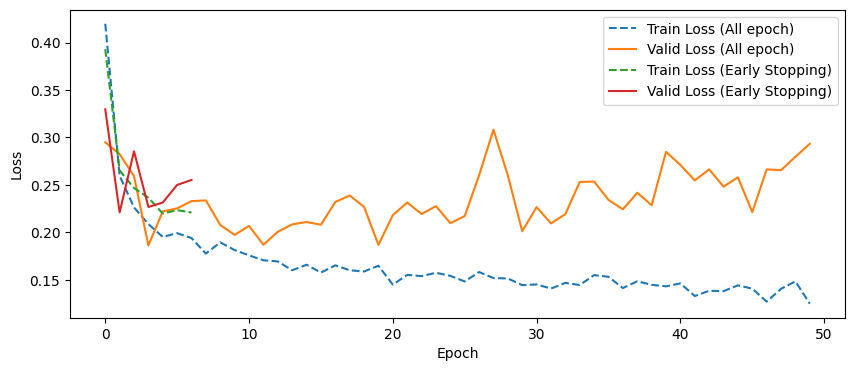

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L1, L2 적용 

In [37]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                
        val_loss /=  len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)
        
        print(f'epoch {epoch + 1} | Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters()) # 모델이 가진 가중치를 가져와서 합산 
        weight_norms.append(weight_norm)    # 가져와서 합산한 가중치를 리스트에 추가

    return train_losses, val_losses, weight_norms


In [ ]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

print()

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9) # weight decay : l2규제와 연관 
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

epoch 1 | Train loss: 0.4785, Val loss: 0.2522, Accuracy: 0.9277
epoch 2 | Train loss: 0.1990, Val loss: 0.1632, Accuracy: 0.9523
epoch 3 | Train loss: 0.1464, Val loss: 0.1431, Accuracy: 0.9576
epoch 4 | Train loss: 0.1160, Val loss: 0.1366, Accuracy: 0.9587
epoch 5 | Train loss: 0.0954, Val loss: 0.1178, Accuracy: 0.9656
epoch 6 | Train loss: 0.0872, Val loss: 0.1106, Accuracy: 0.9691
epoch 7 | Train loss: 0.0727, Val loss: 0.1072, Accuracy: 0.9683
epoch 8 | Train loss: 0.0676, Val loss: 0.1045, Accuracy: 0.9702
epoch 9 | Train loss: 0.0627, Val loss: 0.1043, Accuracy: 0.9699
epoch 10 | Train loss: 0.0534, Val loss: 0.0968, Accuracy: 0.9723

epoch 1 | Train loss: 0.5016, Val loss: 0.2974, Accuracy: 0.9141
epoch 2 | Train loss: 0.2715, Val loss: 0.2515, Accuracy: 0.9283
epoch 3 | Train loss: 0.2377, Val loss: 0.2163, Accuracy: 0.9413
epoch 4 | Train loss: 0.2202, Val loss: 0.2196, Accuracy: 0.9384
epoch 5 | Train loss: 0.2059, Val loss: 0.2130, Accuracy: 0.9394
epoch 6 | Train loss: 0

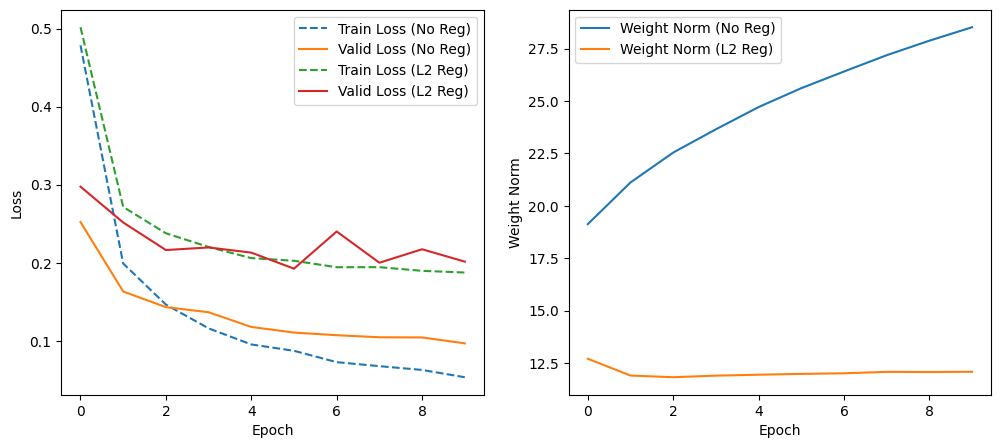

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 Reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()